In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

import torch

import pennylane as qml
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
from pennylane import numpy as qnp

from PIL import Image

import time
import warnings
warnings.filterwarnings("ignore")

## Extracting Hearts Image

In [2]:
img = Image.open("/Users/akashmalemath/Documents/master_work/qcbm_hiwi/qcbm_project/bars_stripes_cat/heart_template.png").convert("L")
img = torch.tensor(np.array(img))/255.0

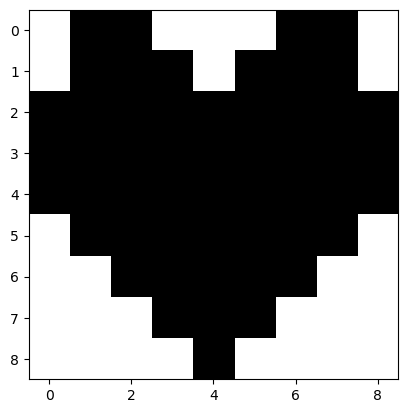

In [3]:
plt.imshow(img, cmap='gray')

In [4]:
img = img.flatten()
# img = (img > 0.5).int()

In [5]:
norm_img = img / torch.linalg.norm(img)

## Getting Wavefunction of Dataset

In [6]:
n_qubits = math.ceil(math.log2(img.shape[0]))

In [7]:
padded = torch.zeros(2**n_qubits)
padded[:norm_img.shape[0]] = norm_img

In [8]:
n_ancillas = 1
total_qubits = n_qubits + n_ancillas

In [9]:
bitstrings_target = ['0000','0011','0101','1010','1100','1111']
nums_target = torch.tensor([int(b,2) for b in bitstrings_target],dtype=torch.long)

In [10]:
wavefunctions = torch.zeros((len(nums_target),2**n_qubits), dtype=torch.float32)
wavefunctions[torch.arange(len(nums_target)),nums_target] = 1.0

dm_batch = torch.einsum("bi,bj->bij",wavefunctions,wavefunctions)
target_dm = dm_batch.mean(dim=0)

In [11]:
##### For training over the register basis
bitstrings_full_target = ['0000000','0011001','0101010','1010011','1100100','1111101']
nums_full_target = torch.tensor([int(b,2) for b in bitstrings_full_target],dtype=torch.long)

wavefunctions_full = torch.zeros((len(nums_full_target),2**total_qubits), dtype=torch.float32)
wavefunctions_full[torch.arange(len(nums_full_target)),nums_full_target] = 1.0

dm_batch_full = torch.einsum("bi,bj->bij",wavefunctions_full,wavefunctions_full)
target_dm_full = dm_batch_full.mean(dim=0)

## Functions

In [12]:
from pennylane.math import reduce_statevector

def sqrtm_torch(matrix:torch.Tensor) -> torch.Tensor:

    eigvals, eigvecs = torch.linalg.eig(matrix)
    eigvals = torch.sqrt(eigvals)
    return eigvecs @ torch.diag(eigvals) @ torch.linalg.inv(eigvecs)


def trdistance_loss(px:torch.Tensor, py:torch.Tensor) -> torch.Tensor:
    
    pxy = px - py
    pxy_2 = pxy @ pxy
    dagger_pxy2 = pxy_2.conj().T
    tr_distance = 0.5 * torch.trace(sqrtm_torch(dagger_pxy2 @ pxy_2))
    return tr_distance.real



def qcbm(circuit_fn, params:torch.Tensor, py:torch.Tensor, num_qubits=n_qubits):

    full_psi = circuit_fn(params)
    px = reduce_statevector(full_psi, indices=range(num_qubits))
    loss = trdistance_loss(px, py)
    return loss


In [13]:
def qcbm_circuit(params,total_qubits):

    rz_params = params[:total_qubits]
    ising_params1 = params[total_qubits:2*total_qubits]
    ising_params2 = params[2*total_qubits:]

    for i in range(total_qubits):
        qml.RX(rz_params[i],wires=i)

    for i in range(total_qubits-1):
        qml.IsingXY(ising_params1[i],wires=[i,i+1])
    qml.IsingXY(ising_params1[-1],wires=[total_qubits-1,0])

    for i in range(total_qubits-1):
        qml.IsingZZ(ising_params2[i],wires=[i,i+1])
    qml.IsingZZ(ising_params2[-1],wires=[total_qubits-1,0])


dev = qml.device("default.qubit",wires=total_qubits)
folds = 3

@qml.qnode(dev,interface="torch")
def circuit(input_params,folds=folds,num_qubits=n_qubits,ancilla_qubits=n_ancillas,total_qubits=total_qubits):

    for i in range(total_qubits):

        ## 1010.... initial state
        if i%2 == 0:
            qml.X(i)

    for i in range(folds):
        qcbm_circuit(params=input_params[i],total_qubits=total_qubits)
    
    output1 = qml.state()

    return output1


In [14]:
def fidelity_loss(px:torch.Tensor, py:torch.Tensor) -> torch.Tensor:
    """
    Computes the fidelity loss between two quantum states.
    """
    px_dm = qml.math.dm_from_state_vector(px)

    return -1*qml.math.fidelity(px_dm,py) 

def vqc(circuit_fn,  params:torch.Tensor, py:torch.Tensor, num_qubits=n_qubits):
    """
    Variational Quantum Circuit (VQC) function to compute the loss.
    """
    full_psi = circuit_fn(params)
    fid_loss = fidelity_loss(full_psi, py)
    return fid_loss.real

## Training the Model

In [15]:
initial_params = torch.rand((folds, 3 * total_qubits), requires_grad=True, dtype=torch.float32)

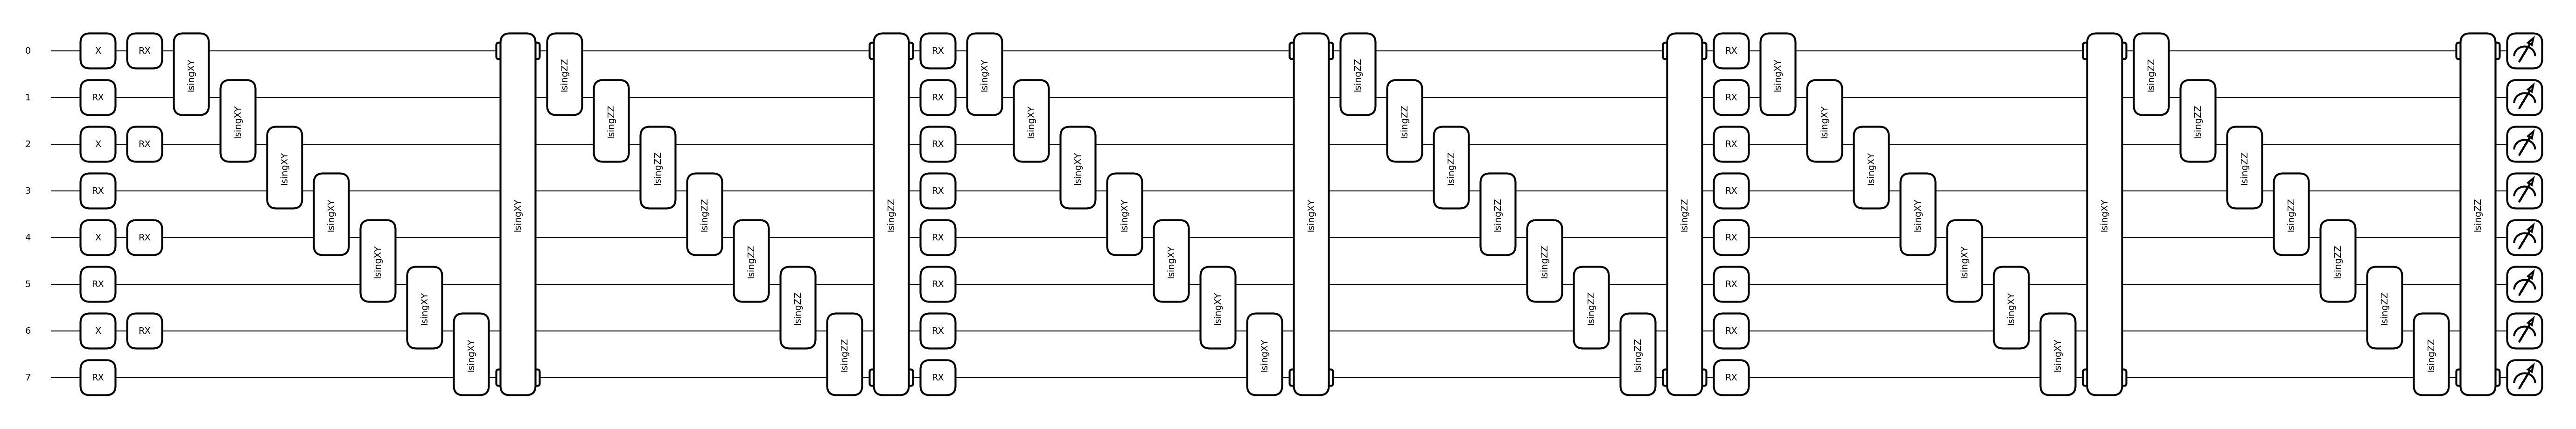

In [16]:
qml.draw_mpl(circuit,device='default')(initial_params)
plt.show()

In [17]:
weights = initial_params
lr = 0.1
opt = torch.optim.Adam([weights], lr=lr)


loss_history = []
min_loss = qcbm(circuit, weights, target_dm)
optimal_params = torch.zeros((folds, 3* total_qubits), dtype=torch.float32)
n_epochs = 2000
i = 0

while i < n_epochs:

    i += 1
    start_time = time.time()
    opt.zero_grad()
    loss = qcbm(circuit, weights, target_dm)
    loss.backward()
    opt.step()
    end_time = time.time()

    if i%10 == 0:
        print(f"Step: {i} Loss: {loss} Time taken per iter: {end_time-start_time}")
    loss_history.append(loss.item())

    if loss < min_loss:
        min_loss = loss
        optimal_params = weights.detach().clone()


Step: 10 Loss: 0.2791483148111334 Time taken per iter: 0.02644491195678711
Step: 20 Loss: 0.24526040129928117 Time taken per iter: 0.024423837661743164
Step: 30 Loss: 0.21432720388962856 Time taken per iter: 0.024116039276123047
Step: 40 Loss: 0.17887319567613322 Time taken per iter: 0.023533105850219727
Step: 50 Loss: 0.1686444777788932 Time taken per iter: 0.025053977966308594
Step: 60 Loss: 0.16808084896868433 Time taken per iter: 0.024460792541503906
Step: 70 Loss: 0.16717462697888172 Time taken per iter: 0.023151159286499023
Step: 80 Loss: 0.1669001954375942 Time taken per iter: 0.02466416358947754
Step: 90 Loss: 0.1667634674794481 Time taken per iter: 0.023150205612182617
Step: 100 Loss: 0.16670570740208898 Time taken per iter: 0.023562908172607422
Step: 110 Loss: 0.1666913038915371 Time taken per iter: 0.023627042770385742
Step: 120 Loss: 0.16668419988868383 Time taken per iter: 0.02309393882751465
Step: 130 Loss: 0.16667870278755292 Time taken per iter: 0.023249149322509766
Ste

RuntimeError: torch.linalg.eig: input tensor should not contain infs or NaNs.

Text(0.5, 1.0, 'Loss Over Epochs')

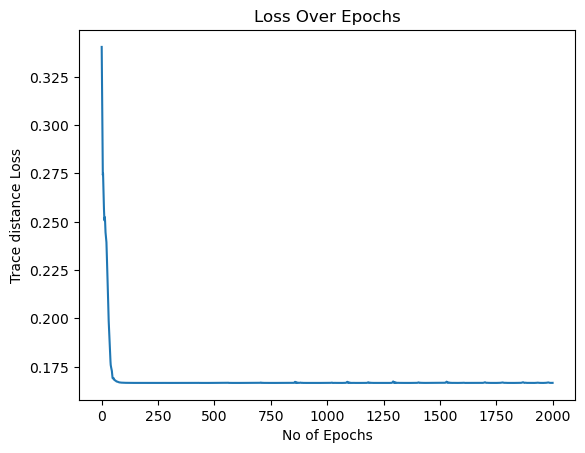

In [ ]:
plt.plot(loss_history)
plt.xlabel("No of Epochs")
plt.ylabel("Trace distance Loss")
plt.title("Loss Over Epochs")

In [ ]:
min_loss = loss_history[np.argmin(loss_history)]

print(f"The model converges to the Trace Distance Loss of {min_loss}")

The model converges to the Trace Distance Loss of 0.16666659082731775


In [ ]:
psi = circuit(optimal_params)
reduced_dm = reduce_statevector(psi,indices=range(n_qubits))

In [ ]:
np.round(np.diag(reduced_dm),4)

array([0.    -0.j, 0.    -0.j, 0.    -0.j, 0.    -0.j, 0.    +0.j,
       0.    -0.j, 0.    -0.j, 0.    +0.j, 0.    -0.j, 0.    +0.j,
       0.3537-0.j, 0.    -0.j, 0.1463-0.j, 0.    -0.j, 0.    +0.j,
       0.5   +0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j,
       0.    +0.j, 0.    -0.j, 0.    -0.j, 0.    +0.j, 0.    -0.j,
       0.    +0.j, 0.    -0.j, 0.    -0.j, 0.    +0.j, 0.    -0.j,
       0.    +0.j, 0.    -0.j, 0.    -0.j, 0.    +0.j, 0.    +0.j,
       0.    +0.j, 0.    +0.j, 0.    +0.j, 0.    -0.j, 0.    -0.j,
       0.    +0.j, 0.    -0.j, 0.    -0.j, 0.    +0.j, 0.    -0.j,
       0.    +0.j, 0.    +0.j, 0.    -0.j, 0.    -0.j, 0.    +0.j,
       0.    +0.j, 0.    +0.j, 0.    -0.j, 0.    +0.j, 0.    +0.j,
       0.    +0.j, 0.    -0.j, 0.    -0.j, 0.    +0.j, 0.    +0.j,
       0.    +0.j, 0.    -0.j, 0.    +0.j, 0.    +0.j, 0.    -0.j,
       0.    -0.j, 0.    +0.j, 0.    +0.j, 0.    -0.j, 0.    -0.j,
       0.    +0.j, 0.    -0.j, 0.    +0.j, 0.    +0.j, 0.    -

## Training over the Register Basis

In [ ]:
total_qubits

8

In [ ]:
n_qubits+total_qubits-1

14

In [ ]:
def vqc_circuit(params,total_qubits):

    rz_params = params[:total_qubits]
    ising_params1 = params[total_qubits:2*total_qubits]
    ising_params2 = params[2*total_qubits:]

    for i in range(total_qubits):
        qml.RX(rz_params[i],wires=n_qubits+i)

    for i in range(total_qubits-1):
        qml.IsingXY(ising_params1[i],wires=[n_qubits+i,n_qubits+i+1])
    qml.IsingXY(ising_params1[-1],wires=[total_qubits-1,n_qubits])

    for i in range(total_qubits-1):
        qml.IsingZZ(ising_params2[i],wires=[n_qubits+i,n_qubits+i+1])
    qml.IsingZZ(ising_params2[-1],wires=[total_qubits-1,n_qubits])


dev = qml.device("default.qubit",wires=total_qubits)
folds = 3

@qml.qnode(dev,interface="torch")
def reg_circuit(input_params,trained_params=optimal_params,folds=folds,num_qubits=n_ancillas,total_qubits=total_qubits):
    
    for i in range(total_qubits):
        ## 1010.... initial state
        if i%2 == 0:
            qml.X(i)

    for i in range(folds):
        qcbm_circuit(params=trained_params[i],total_qubits=total_qubits)

    for i in range(folds):
        vqc_circuit(params=input_params[i],total_qubits=n_ancillas)
    
    output = qml.state()

    return output


In [ ]:
reg_params = torch.rand((folds, 3 * n_ancillas), requires_grad=True, dtype=torch.float32)

In [ ]:
qml.draw_mpl(reg_circuit)(reg_params)

WireError: Wires must be unique; got [7, 7].

In [ ]:
weights = reg_params
opt = torch.optim.Adam([weights], lr=0.01)

reg_loss_history = []
optimal_reg_params = torch.zeros((folds, 3 * n_ancillas), dtype=torch.float32)
min_loss = vqc(reg_circuit, weights, target_dm_full)
n_epochs = 2000
i = 0

while i < n_epochs:

    i += 1
    start_time = time.time()
    opt.zero_grad()
    loss_val = vqc(reg_circuit, weights, target_dm_full)
    loss_val.backward()
    opt.step()
    end_time = time.time()

    if i%10 == 0:
        print(f"Step: {i} Loss: {loss_val} Time taken per iter: {end_time-start_time}")
    reg_loss_history.append(loss_val)

    if loss_val < min_loss:
        min_loss = loss_val
        optimal_reg_params = weights.detach().clone()


Step: 10 Loss: -0.0255046152336857 Time taken per iter: 0.02112603187561035
Step: 20 Loss: -0.03415166791148406 Time taken per iter: 0.020380020141601562
Step: 30 Loss: -0.042259756336980966 Time taken per iter: 0.022883176803588867
Step: 40 Loss: -0.05072887645162949 Time taken per iter: 0.02373194694519043
Step: 50 Loss: -0.06043592900968613 Time taken per iter: 0.02341008186340332
Step: 60 Loss: -0.07190206132254322 Time taken per iter: 0.022935152053833008
Step: 70 Loss: -0.08413033083497985 Time taken per iter: 0.022930145263671875
Step: 80 Loss: -0.0955252787091317 Time taken per iter: 0.021629810333251953
Step: 90 Loss: -0.1058991604794193 Time taken per iter: 0.02483391761779785
Step: 100 Loss: -0.11436476603290105 Time taken per iter: 0.022073984146118164
Step: 110 Loss: -0.12023579753213758 Time taken per iter: 0.024331092834472656
Step: 120 Loss: -0.12394104301657535 Time taken per iter: 0.022366046905517578
Step: 130 Loss: -0.12621081323699787 Time taken per iter: 0.0215833

In [ ]:
full_psi = reg_circuit(optimal_reg_params)

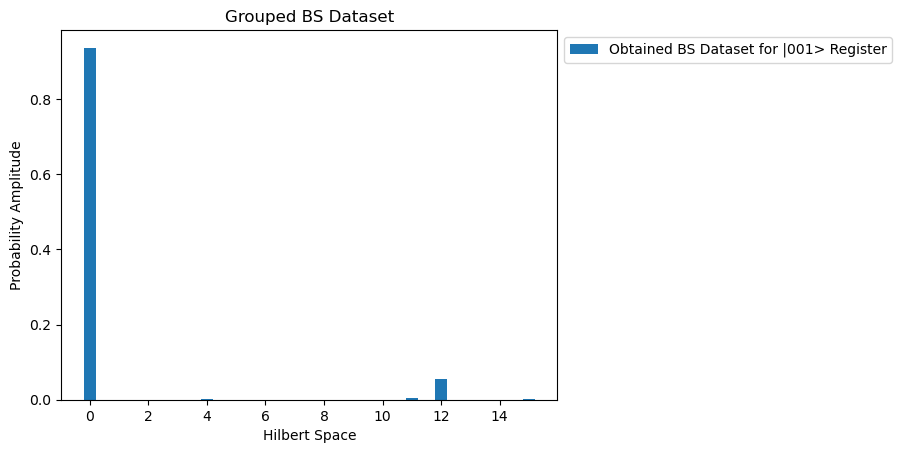

In [ ]:
image = qnp.round(full_psi[::8],3)
image /= qnp.linalg.norm(image)

w, x = 0.4, np.arange(len(image))

# plt.bar(x - w/2, target_psi, w, label='Original BS Dataset')
plt.bar(x, np.abs(image)**2, w, label='Obtained BS Dataset for |001> Register')

plt.xlabel('Hilbert Space')
plt.ylabel('Probability Amplitude')
plt.title('Grouped BS Dataset')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()